# Imports

In [1]:
import torch
import torch.nn as nn
import random
import hashlib
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from scipy.ndimage import gaussian_filter
from skimage import exposure
import os
from shutil import copyfile
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
import torch.nn.functional as F


import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split


# Define transform

In [2]:
transform = transforms.Compose([
    transforms.Resize(224),              
    transforms.CenterCrop(224),          
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Data Loaders

In [3]:
# Load the dataset
dataset = datasets.ImageFolder(r'augmented_data', transform=transform)

# Splitting the dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

torch.manual_seed(42)

batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


# Display a batch of images

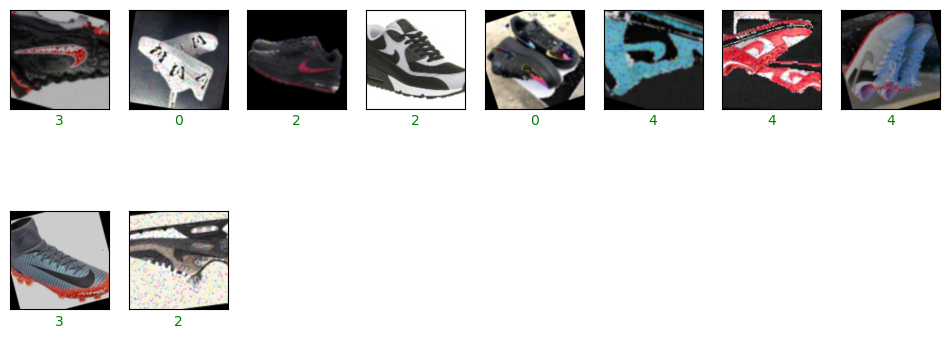

In [4]:
# Function to show a batch of images
def show_images(images, labels, preds):
    plt.figure(figsize=(12, 10))
    for i, image in enumerate(images):
        plt.subplot(4, 8, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)

        col = 'green' if preds[i] == labels[i] else 'red'
        plt.xlabel(f'{preds[i]}', color=col)

# Get a batch of training data
images, labels = next(iter(train_loader))
show_images(images, labels, labels)


# Calculating the number of parameters

In [5]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [6]:
# plt.plot(train_losses, label='training loss')
# plt.plot(test_losses, label='validation loss')
# plt.title('Loss at the end of each epoch')
# plt.legend();

In [7]:
# #plt.plot([t/180 for t in train_correct], label='training accuracy')
# #plt.plot([t/60 for t in test_correct], label='validation accuracy')
# plt.plot([t/80 for t in train_correct], label='training accuracy')
# plt.plot([t/30 for t in test_correct], label='validation accuracy')
# plt.title('Accuracy at the end of each epoch')
# plt.legend();

# Pre-Trained Model - AlexNet

In [8]:
AlexNet_model = models.alexnet(pretrained=True)
AlexNet_model

/home/yair7799/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/yair7799/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Freeze feature parameters
We want to freeze the pre-trained weights and biases. we set .requires_grad to False so we don't backprop through them

In [9]:
for param in AlexNet_model.parameters():
    param.requires_grad = False

## Modify the classifier
Next we need to modify the fully connected layers to produce a binary output. The section is labeled "classifier" in the AlexNet model.<br>
Note that when we assign new layers, their parameters default to <tt>.requires_grad=True</tt>.

In [10]:
torch.manual_seed(42)
AlexNet_model.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                        nn.ReLU(),
                                        nn.Dropout(0.4),
                                        nn.Linear(1024, 5),
                                        nn.LogSoftmax(dim=1))
AlexNet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, 

In [11]:
count_parameters(AlexNet_model)

 9437184
    1024
    5120
       5
________
 9443333


## Define loss function & optimizer
We only want to optimize the classifier parameters, as the feature parameters are frozen.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(AlexNet_model.classifier.parameters(), lr=0.0001)

## Train the model
Remember, we're only training the fully connected layers. The convolutional layers have fixed weights and biases. For this reason, we only need to run one epoch.

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# approximately 16 minutes for all data -- with limit approximately 8 minutes
import time

start_time = time.time()

epochs = 8

max_train_batch = 2300
max_test_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Move the model to CUDA if available
AlexNet_model = AlexNet_model.to(device)

for i in range(epochs):
    train_corr = 0
    test_corr = 0

    # run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):

        # limit the number of batches 
        if b == max_train_batch:
            break
        
        b += 1
        # Move data to CUDA
        X_train, y_train = X_train.to(device), y_train.to(device)

        # apply the model
        y_pred = AlexNet_model(X_train)
        loss = criterion(y_pred, y_train)

        # count the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        train_corr += batch_corr

        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print results
        if b % 10 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10 * b:6}/18743]  loss: {loss.item():10.8f}  '
                  f'accuracy: {train_corr.item() * 100 / (10 * b):7.3f}%')

    train_losses.append(loss.detach().cpu().numpy())
    train_correct.append(train_corr.item())

    # run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # limit the number of batches 
            if b == max_test_batch:
                break

            # Move data to CUDA
            X_test, y_test = X_test.to(device), y_test.to(device)

            # apply the model
            y_val = AlexNet_model(X_test)

            # Count the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1]
            test_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_losses.append(loss.detach().cpu().numpy())
        test_correct.append(test_corr.item())

print(f'\nDuration: {time.time() - start_time:.0f} seconds')  # print the time elapsed


epoch:  0  batch:   10 [   100/18743]  loss: 1.58026659  accuracy:  23.000%
epoch:  0  batch:   20 [   200/18743]  loss: 1.67410874  accuracy:  26.000%
epoch:  0  batch:   30 [   300/18743]  loss: 1.63644087  accuracy:  30.333%
epoch:  0  batch:   40 [   400/18743]  loss: 1.06408572  accuracy:  35.500%
epoch:  0  batch:   50 [   500/18743]  loss: 1.67919159  accuracy:  36.800%
epoch:  0  batch:   60 [   600/18743]  loss: 1.46759093  accuracy:  38.167%
epoch:  0  batch:   70 [   700/18743]  loss: 1.26675069  accuracy:  39.429%
epoch:  0  batch:   80 [   800/18743]  loss: 0.70412779  accuracy:  41.250%
epoch:  0  batch:   90 [   900/18743]  loss: 1.73112488  accuracy:  40.889%
epoch:  0  batch:  100 [  1000/18743]  loss: 1.39999366  accuracy:  42.100%
epoch:  0  batch:  110 [  1100/18743]  loss: 1.05365431  accuracy:  43.455%
epoch:  0  batch:  120 [  1200/18743]  loss: 0.55684119  accuracy:  44.083%
epoch:  0  batch:  130 [  1300/18743]  loss: 0.89208949  accuracy:  44.846%
epoch:  0  b

In [14]:
# Print accuracy for the final epoch
final_train_accuracy = train_correct[-1] * 100 / len(train_loader.dataset)
final_test_accuracy = test_correct[-1] * 100 / len(test_loader.dataset)
print(f'\nFinal Training Accuracy: {final_train_accuracy:.2f}%')
print(f'Final Testing Accuracy: {final_test_accuracy:.2f}%')



Final Training Accuracy: 99.92%
Final Testing Accuracy: 77.91%


## Run a new image through the model

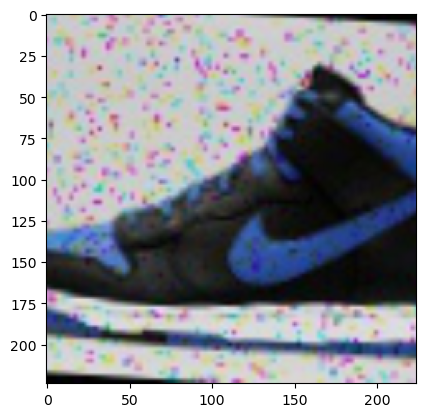

In [15]:
import torch
from torchvision import transforms

# Define the inverse normalization function
def inv_normalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    tensor_mut = tensor.clone()
    for t, m, s in zip(tensor_mut, mean, std):
        t.mul_(s).add_(m)  # Multiply by std and add mean
    return tensor_mut

# Assuming test_data[x][0] is a normalized image tensor
x = 368
im = inv_normalize(test_data[x][0])

# Convert tensor to image and display
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))


In [16]:
test_data[x][0].shape

torch.Size([3, 224, 224])

In [17]:
# CNN Model Prediction:

AlexNet_model.eval()

# Move the model back to CPU
AlexNet_model = AlexNet_model.to('cpu')

with torch.no_grad():
    new_pred = AlexNet_model(test_data[x][0].view(1, 3, 224, 224)).argmax()

# Move the prediction back to CPU
new_pred = new_pred.to('cpu')

print(f'Predicted value: {new_pred.item()} {[new_pred.item()]}')

Predicted value: 4 [4]
